In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Implementation of Decision Making Model in Roach et al 2023

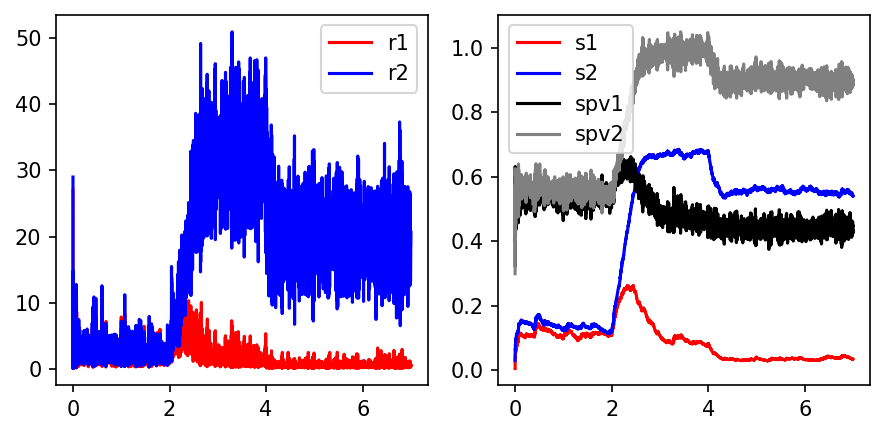

In [84]:
def single_run(GRIK4 = 0., D2 = 0.):
    
    # ---------- PARAMS ------------
    # firing rate 
    aE = 310
    bE = 125
    dE = 0.16

    aI = 615 
    bI = 177 
    dI = 0.087

    T = 7.      # [s]
    dt = 0.002  # [s]
    Tstim = 2.  # [s]
    Tdur  = 2. # [s]
    NT = int(T/dt)
    timerange = np.linspace(0,T, NT)

    sigma = 0.2       # nA
    tauN = 0.100      # slow excitatory synaptic time constant
    tauG = 0.005    # [s] inhibitory synaptic time constant
    tauA = 0.002        # [s]

    Jampa_ext = 5.2e-4 # nA
    mu = 40
    coh = 0
    gwn = np.random.randn(NT, 4)

    gamma = 0.641   # firing rate to NMDA activation multiplier

    JNE = 0.42345756
    JNI = 0.57431432
    JGE = -0.46992407
    JGI = -0.64211589

    I0E = 0.77071143
    I0I = 1.02669666

    See = 0.32
    Sei = 0.25
    Sie = 0
    Sii = 0

    Ns = 2
    w_e = 1
    w_i = 1

    # adjacency matrix
    what_ee = Ns*w_e/(Ns + See*(2 - Ns)) 
    what_ei = Ns*w_e/(Ns + Sei*(2 - Ns)) 
    what_ie = Ns*w_i/(Ns + Sie*(2 - Ns)) 
    what_ii = Ns*w_i/(Ns + Sii*(2 - Ns)) 

    wpee = what_ee + See*what_ee 
    wmee = what_ee - See*what_ee 

    wpei = what_ei + Sei*what_ei 
    wmei = what_ei - Sei*what_ei 

    wpie = what_ie + Sie*what_ie 
    wmie = what_ie - Sie*what_ie 

    wpii = what_ii + Sii*what_ii 
    wmii = what_ii - Sii*what_ii 

    A = np.zeros([4,4]) 

    A[0,:] = [wpee*JNE,wmee*JNE,wpie*JGE,wmie*JGE]  #inputs to E1
    A[1,:] = [wmee*JNE,wpee*JNE,wmie*JGE,wpie*JGE]  #inputs to E2
    A[2,:] = [wpei*JNI,wmei*JNI,wpii*JGI,wmii*JGI]  #inputs to I1
    A[3,:] = [wmei*JNI,wpei*JNI,wmii*JGI,wpii*JGI]  #inputs to I2
    
    Ieta1 = np.zeros(NT+1)
    Ieta2 = np.zeros(NT+1)
    IetaPV1 = np.zeros(NT+1)
    IetaPV2 = np.zeros(NT+1)
    
    SE1_init = (np.random.rand()*0.05 + 0.0)
    SE2_init = (np.random.rand()*0.05 + 0.0)
    SI1_init = (np.random.rand()*0.05 + 0.275)
    SI2_init = (np.random.rand()*0.05 + 0.275)

    S1 = SE1_init*np.ones(NT+1)
    S2 = SE2_init*np.ones(NT+1) 
    SPV1 = SI1_init*np.ones(NT+1)
    SPV2 = SI2_init*np.ones(NT+1)

    r1 = np.zeros(NT)
    r2 = np.zeros(NT)
    rPV1 = np.zeros(NT)
    rPV2 = np.zeros(NT)
    
    for t, time in enumerate(timerange): #Loop through time for a trial

        #---- Stimulus------------------------------------------------------
        Istim1 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jampa_ext*mu*(1+coh/100)) # To population 1
        Istim2 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jampa_ext*mu*(1-coh/100)) # To population 2
                
        # Total synaptic input
        s_array = np.array([S1[t], S2[t], SPV1[t], SPV2[t]])
        I1 = np.dot(A[0], s_array) + I0E + Istim1 + Ieta1[t]
        I2 = np.dot(A[1], s_array) + I0E + Istim2 + Ieta2[t]
        IPV1 = np.dot(A[2], s_array) + I0I + GRIK4*0.01 + IetaPV1[t]
        IPV2 = np.dot(A[3], s_array) + I0I + GRIK4*0.01 + IetaPV2[t]

        # Transfer function to get firing rate
        r1[t]  = F(I1, aE, bE, dE)
        r2[t]  = F(I2, aE, bE, dE)
        rPV1[t] = F(IPV1, aI, bI, dI)
        rPV2[t] = F(IPV2, aI, bI, dI)
    
        #---- Dynamical equations -------------------------------------------

        # Mean NMDA-mediated synaptic dynamics updating
        S1[t+1] = S1[t] + dt*(-S1[t]/tauN + (1-S1[t])*gamma*r1[t])
        S2[t+1] = S2[t] + dt*(-S2[t]/tauN + (1-S2[t])*gamma*r2[t])

        # Mean GABA synapses
        SPV1[t+1] = SPV1[t] + dt*(-SPV1[t]/tauG + rPV1[t])
        SPV2[t+1] = SPV2[t] + dt*(-SPV2[t]/tauG + rPV2[t])

        # Ornstein-Uhlenbeck generation of noise in pop1 and 2
        Ieta1[t+1] = Ieta1[t] + (dt/tauA) * (-Ieta1[t]) + np.sqrt(tauA)*sigma*gwn[t,0]
        Ieta2[t+1] = Ieta2[t] + (dt/tauA) * (-Ieta2[t]) + np.sqrt(tauA)*sigma*gwn[t,1]
        IetaPV1[t+1] = IetaPV1[t] + (dt/tauA) * (-IetaPV1[t]) + np.sqrt(tauA)*sigma*gwn[t,2]
        IetaPV2[t+1] = IetaPV2[t] + (dt/tauA) * (-IetaPV2[t]) + np.sqrt(tauA)*sigma*gwn[t,3]

    return {'r1':r1, 'r2':r2, 'rPV1':rPV1, 'rPV2':rPV2,
            's1':S1[:-1], 's2':S2[:-1], 'spv1':SPV1[:-1], 'spv2':SPV2[:-1],
            't':timerange}

data = single_run()
fig, axs = plt.subplots(1,2, figsize=(6,3), dpi=150)

axs[0].plot(data['t'], data['r1'], label='r1', color = 'red')
axs[0].plot(data['t'], data['r2'], label='r2', color = 'blue')
# axs[0].plot(data['t'], data['rPV1'], label='rPV1', color = 'black')
# axs[0].plot(data['t'], data['rPV2'], label='rPV2', color = 'grey')
axs[0].legend()

axs[1].plot(data['t'], data['s1'], label='s1', color = 'red')
axs[1].plot(data['t'], data['s2'], label='s2', color = 'blue')
axs[1].plot(data['t'], data['spv1'], label='spv1', color = 'black')
axs[1].plot(data['t'], data['spv2'], label='spv2', color = 'grey')
axs[1].legend()

plt.tight_layout()


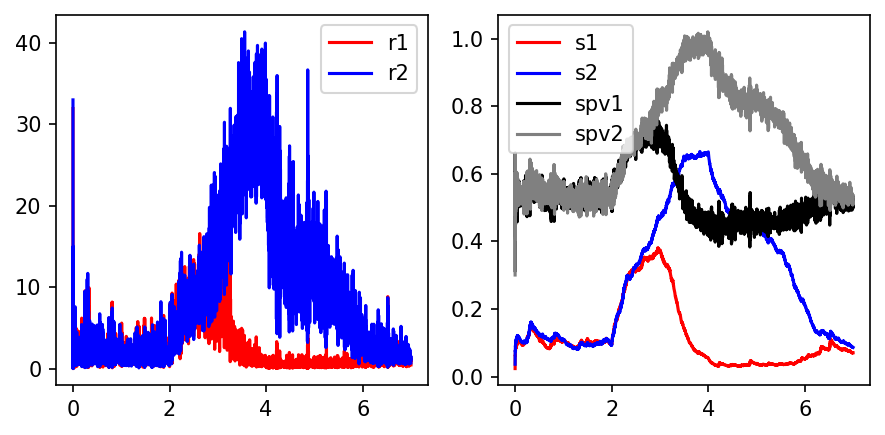

In [88]:
data = single_run(GRIK4=0.8)
fig, axs = plt.subplots(1,2, figsize=(6,3), dpi=150)

axs[0].plot(data['t'], data['r1'], label='r1', color = 'red')
axs[0].plot(data['t'], data['r2'], label='r2', color = 'blue')
# axs[0].plot(data['t'], data['rPV1'], label='rPV1', color = 'black')
# axs[0].plot(data['t'], data['rPV2'], label='rPV2', color = 'grey')
axs[0].legend()

axs[1].plot(data['t'], data['s1'], label='s1', color = 'red')
axs[1].plot(data['t'], data['s2'], label='s2', color = 'blue')
axs[1].plot(data['t'], data['spv1'], label='spv1', color = 'black')
axs[1].plot(data['t'], data['spv2'], label='spv2', color = 'grey')
axs[1].legend()

plt.tight_layout()